# Structure
* Perform basic analysis: counts, means, std max etc
* Basic EDA to understand data dynamics: distribution of the model, independence
* Statistical tests to confirm
  * Goals are Poisson distributed
  * In/dependece between home/away goals
  * Significant difference between home/away goals
Assumptions for model by Dixon are satisfied and we can proceed to implement the model to estimate probabilities of team encounter results.

In [1]:
from football_odds.models import DoublePoisson
from football_odds.utils.connectors import QuestDB
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu, poisson_means_test, poisson, chisquare, chi2_contingency

In [2]:
Q = r'''
select
  dlf.league_name, 
  dlf.season,
  dff.fixture_date,
  dtfh.team_name as home_team_name, 
  dtfa.team_name as away_team_name, 
  dff.teams_home_winner, 
  CASE
    WHEN dff.goals_home = dff.goals_away THEN 'DRAW' 
    WHEN dff.goals_home > dff.goals_away THEN 'HOME'
    WHEN dff.goals_home < dff.goals_away THEN 'AWAY'
  END as winner,
  dff.goals_home, 
  dff.goals_away,
from dim_fixtures_fa dff
inner join dim_leagues_fa dlf
  on dlf.league_id = dff.league_id and dff.league_season = dlf.season
inner join dim_teams_fa dtfh
  on dtfh.team_id = dff.teams_home_id
inner join dim_teams_fa dtfa
  on dtfa.team_id = dff.teams_away_id
where 1=1
  and dlf.league_name IN ('Premier League')
  and goals_home is not null and goals_away is not null
  and season >= 2021
;
'''

conn = QuestDB()
df = conn.execute_query(Q)
df['goal_difference'] = (df.goals_home - df.goals_away).abs()
df['total_goals'] = (df.goals_home + df.goals_away)

**[2024-02-12 11:06:19.679318]
select
  dlf.league_name,
  dlf.season,
  dff.fixture_date,
  dtfh.team_name as home_team_name,
  dtfa.team_name as away_team_name,
  dff.teams_home_winner,
  CASE
    WHEN dff.goals_home = dff.goals_away THEN 'DRAW'
    WHEN dff.goals_home > dff.goals_away THEN 'HOME'
    WHEN dff.goals_home < dff.goals_away THEN 'AWAY'
  END as winner,
  dff.goals_home,
  dff.goals_away,
from dim_fixtures_fa dff
inner join dim_leagues_fa dlf
  on dlf.league_id = dff.league_id and dff.league_season = dlf.season
inner join dim_teams_fa dtfh
  on dtfh.team_id = dff.teams_home_id
inner join dim_teams_fa dtfa
  on dtfa.team_id = dff.teams_away_id
where 1=1
  and dlf.league_name IN ('Premier League')
  and goals_home is not null and goals_away is not null
  and season >= 2021
;
**[2024-02-12 11:06:20.865529] Ended executing Query


## Summary Statistics

* We have a sample size of 860 games
* An average of 2.9 goals are scored per match
* The average number of home goals is almost 1.6 while away goals are 1.3. Is this statistically significant?
* The variation of home goals is slightly larger than that of away goals. How can this impact the results?
* The Liverpool-Bournmouth 2022-08-27 match ended 9-0, the largest number of home goals scored
* The Sheffield-Newcastle 2023-09-23 match ended 9-0, the largest number of home goals scored
* Should we truncate the high goals scored to something more reasonable to not skew the results? How to test this?

In [3]:
df.describe()

,season,fixture_date,goals_home,goals_away,goal_difference,total_goals
count,860.000000,860,860.000000,860.000000,860.000000,860.000000
mean,2021.674419,2022-08-29 19:09:00,1.581395,1.276744,1.497674,2.858140
min,2021.000000,2021-08-12 22:00:00,0.000000,0.000000,0.000000,0.000000
25%,2021.000000,2022-02-07 05:00:00,1.000000,0.000000,1.000000,2.000000
50%,2022.000000,2022-09-01 22:00:00,1.000000,1.000000,1.000000,3.000000
75%,2022.000000,2023-03-17 23:00:00,2.000000,2.000000,2.000000,4.000000
max,2023.000000,2023-10-28 22:00:00,9.000000,8.000000,9.000000,9.000000
std,0.672802,NaN,1.370444,1.226471,1.321883,1.692513


In [4]:
df.sort_values('goals_home', ascending=False).head(8)

,league_name,season,fixture_date,home_team_name,away_team_name,teams_home_winner,winner,goals_home,goals_away,goal_difference,total_goals
414,Premier League,2022,2022-08-26 22:00:00,Liverpool,Bournemouth,True,HOME,9,0,9,9
81,Premier League,2021,2021-10-22 22:00:00,Chelsea,Norwich,True,HOME,7,0,7,7
629,Premier League,2022,2023-03-04 23:00:00,Liverpool,Manchester United,True,HOME,7,0,7,7
159,Premier League,2021,2021-12-13 23:00:00,Manchester City,Leeds,True,HOME,7,0,7,7
444,Premier League,2022,2022-09-16 22:00:00,Tottenham,Leicester,True,HOME,6,2,4,8
693,Premier League,2022,2023-04-22 22:00:00,Newcastle,Tottenham,True,HOME,6,1,5,7
454,Premier League,2022,2022-10-01 22:00:00,Manchester City,Manchester United,True,HOME,6,3,3,9
246,Premier League,2021,2022-02-22 23:00:00,Liverpool,Leeds,True,HOME,6,0,6,6


In [5]:
df.sort_values('goals_away', ascending=False).head(8)

,league_name,season,fixture_date,home_team_name,away_team_name,teams_home_winner,winner,goals_home,goals_away,goal_difference,total_goals
818,Premier League,2023,2023-09-23 22:00:00,Sheffield Utd,Newcastle,False,AWAY,0,8,8,8
685,Premier League,2022,2023-04-16 22:00:00,Leeds,Liverpool,False,AWAY,1,6,5,7
302,Premier League,2021,2022-04-08 22:00:00,Southampton,Chelsea,False,AWAY,0,6,6,6
361,Premier League,2021,2022-05-14 22:00:00,Watford,Leicester,False,AWAY,1,5,4,6
170,Premier League,2021,2021-12-25 23:00:00,Norwich,Arsenal,False,AWAY,0,5,5,5
89,Premier League,2021,2021-10-23 22:00:00,Manchester United,Liverpool,False,AWAY,0,5,5,5
83,Premier League,2021,2021-10-22 22:00:00,Everton,Watford,False,AWAY,2,5,3,7
725,Premier League,2022,2023-05-07 22:00:00,Brighton,Everton,False,AWAY,1,5,4,6


In [6]:
df.sort_values('goals_away', ascending=False).head(8)

,league_name,season,fixture_date,home_team_name,away_team_name,teams_home_winner,winner,goals_home,goals_away,goal_difference,total_goals
818,Premier League,2023,2023-09-23 22:00:00,Sheffield Utd,Newcastle,False,AWAY,0,8,8,8
685,Premier League,2022,2023-04-16 22:00:00,Leeds,Liverpool,False,AWAY,1,6,5,7
302,Premier League,2021,2022-04-08 22:00:00,Southampton,Chelsea,False,AWAY,0,6,6,6
361,Premier League,2021,2022-05-14 22:00:00,Watford,Leicester,False,AWAY,1,5,4,6
170,Premier League,2021,2021-12-25 23:00:00,Norwich,Arsenal,False,AWAY,0,5,5,5
89,Premier League,2021,2021-10-23 22:00:00,Manchester United,Liverpool,False,AWAY,0,5,5,5
83,Premier League,2021,2021-10-22 22:00:00,Everton,Watford,False,AWAY,2,5,3,7
725,Premier League,2022,2023-05-07 22:00:00,Brighton,Everton,False,AWAY,1,5,4,6


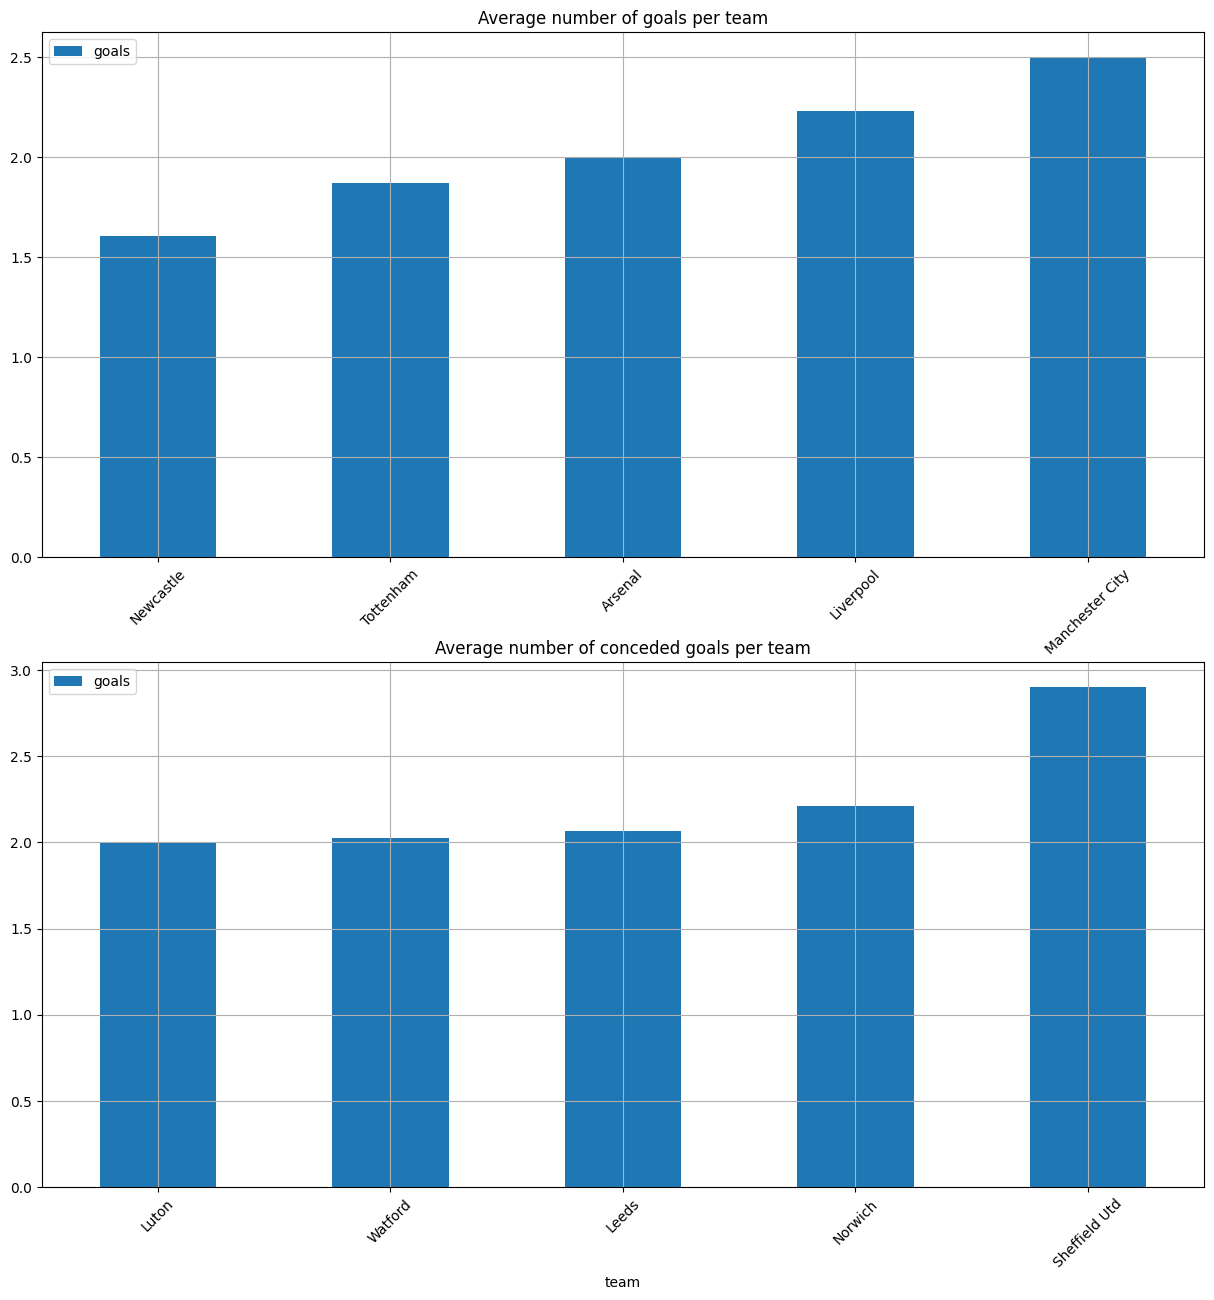

In [26]:
fig, ax = plt.subplots(2, 1, figsize=(15, 15))

# Highest average scoring teams
df_home = df[['home_team_name', 'goals_home']].rename({'home_team_name': 'team', 'goals_home': 'goals'}, axis=1)
df_away = df[['away_team_name', 'goals_away']].rename({'away_team_name': 'team', 'goals_away': 'goals'}, axis=1)
df_team_goals = pd.concat([df_home, df_away])
df_team_goals.groupby('team').mean().sort_values('goals')[-5:].plot.bar(ax=ax[0])
ax[0].grid()
ax[0].set_title('Average number of goals per team')
ax[0].tick_params(axis='x', labelrotation=45)

# Highest average conceding teams
df_home = df[['home_team_name', 'goals_away']].rename({'home_team_name': 'team', 'goals_away': 'goals'}, axis=1)
df_away = df[['away_team_name', 'goals_home']].rename({'away_team_name': 'team', 'goals_home': 'goals'}, axis=1)
df_team_conceded = pd.concat([df_home, df_away])
df_team_conceded.groupby('team').mean().sort_values('goals')[-5:].plot.bar(ax=ax[1])
ax[1].grid()
ax[1].set_title('Average number of conceded goals per team')
ax[1].tick_params(axis='x', labelrotation=45)

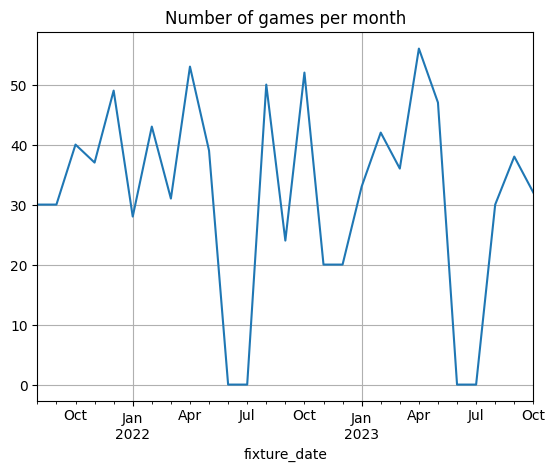

In [8]:
df.set_index('fixture_date').resample('M').league_name.count().plot()
plt.title('Number of games per month')
plt.grid()

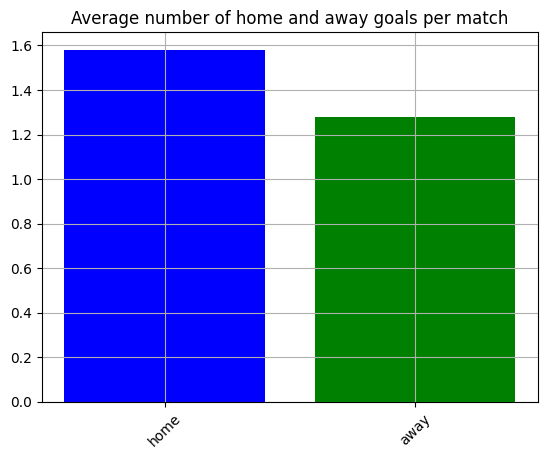

In [9]:
# home/away avg goals
avg_home_goals = df.goals_home.mean()
avg_away_goals = df.goals_away.mean()
plt.bar(['home', 'away'], [avg_home_goals, avg_away_goals], color=['blue', 'green'])
plt.title('Average number of home and away goals per match')
plt.xticks(rotation=45)
plt.grid()

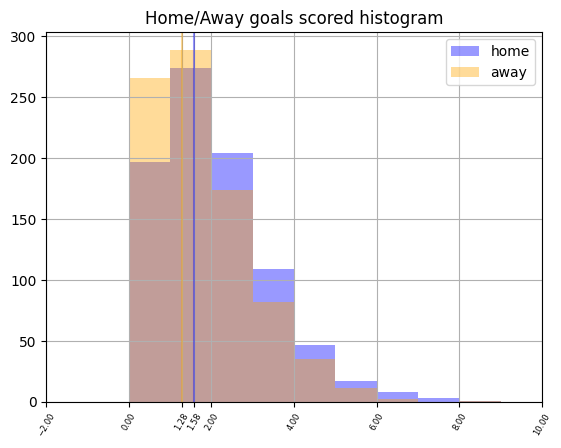

In [21]:
df.goals_home.hist(alpha=0.4, label='home', color='blue', bins=np.arange(0, 10))
df.goals_away.hist(alpha=0.4, label='away', color='orange', bins=np.arange(0, 10))
plt.title('Home/Away goals scored histogram')
plt.axvline(x=avg_home_goals, color='blue', alpha=0.4)
plt.axvline(x=avg_away_goals, color='orange', alpha=0.4)
plt.xticks(list(plt.xticks()[0]) + [avg_home_goals, avg_away_goals], rotation=60, fontsize=6)
plt.legend()

## Poisson Test
We whether the Poisson distribution is a valid distribution for the number of home/away goals.

**H0**: Data comes from a Poisson distribution

**H1**: Data does **not** come from a Poisson Distribution

In [11]:
MLE = df.goals_home.mean()
n_games = len(df)
f_obs = pd.value_counts(df.goals_home).sort_index().values
f_exp = poisson.pmf(list(range(0, df.goals_home.max())), MLE) * n_games
f_exp = np.sum(f_obs) / np.sum(f_exp) * f_exp
    
stat, pval = chisquare(f_obs=f_obs, f_exp=f_exp)
print(f'HOME: Pearson Chi-square p-value={pval:.3f} > 0.05')

MLE = df.goals_away.mean()
n_games = len(df)
f_obs = pd.value_counts(df.goals_away).sort_index().values
f_exp = poisson.pmf(list(range(0, df.goals_away.max())), MLE) * n_games
f_exp = np.sum(f_obs) / np.sum(f_exp) * f_exp
    
stat, pval = chisquare(f_obs=f_obs, f_exp=f_exp)
print(f'AWAY: Pearson Chi-square p-value={pval:.3f} > 0.05')

HOME: Pearson Chi-square p-value=0.019 > 0.05
AWAY: Pearson Chi-square p-value=0.055 > 0.05


## Test for Independence
Chi-Square test assumptions:
* The two samples are independent* No expected cell count is = 0
* 
No more than 20% of the cells have and expected cell count  


### Hypothesis
**H0**: Variables Independent

**H1**: Variables Dependent

After considering only matches with 4 or less goals (95% of all matches) to not violate point 3, we use the Chi-square test and get a p-value of 0.13 > 0.05. There we cannot reject H0, ie. that variables are independent

For details see https://www.pythonfordatascience.org/chi-square-test-of-independence-python/ 

In [12]:
n = 5
num_lt_n_goals = df[(df.goals_away <= n)&(df.goals_home <= n)].league_name.count()
num_games = len(df)
print(f'{num_lt_n_goals} outof {num_games} games ({int(num_lt_n_goals/num_games*100)}%) contain less than {n} goals for both teams')

845 outof 860 games (98%) contain less than 5 goals for both teams


In [13]:
crosstab = pd.crosstab(df.goals_home, df.goals_away)
crosstab

goals_away,0,1,2,3,4,5,6,8
goals_home,,,,,,,,
0,48,63,44,25,11,4,1,1
1,88,88,54,22,16,5,1,0
2,60,67,50,18,7,2,0,0
3,38,44,18,9,0,0,0,0
4,18,18,5,5,1,0,0,0
5,7,7,2,1,0,0,0,0
6,3,2,1,2,0,0,0,0
7,3,0,0,0,0,0,0,0
9,1,0,0,0,0,0,0,0


In [14]:
crosstab = crosstab.iloc[:n, :n]
crosstab

goals_away,0,1,2,3,4
goals_home,,,,,
0,48,63,44,25,11
1,88,88,54,22,16
2,60,67,50,18,7
3,38,44,18,9,0
4,18,18,5,5,1


In [15]:
res = chi2_contingency(crosstab)
print(f'Chi-square test p-value = {res.pvalue:.2f} > 0.05')

Chi-square test p-value = 0.13 > 0.05


## Home Advantage significance
* 24% More home goals scored than away goals
* Mann-Whitney-U: Since p-value < 0.05, we reject null hypothesis, i.e. the home goals scored are statistically greater than the away goals
* Further confirmed by E-test, assuming goals are Poisson distributed: p-value < 0.05

**H0**: home goals = away goals

**H1**: home goals > away goals

In [16]:
print('Home Advantage: {:.2f}'.format(avg_home_goals / avg_away_goals))
res = mannwhitneyu(df.goals_home, df.goals_away, alternative='greater')
print(f'MWU-test p-value = {res.pvalue:.3f}')

Home Advantage: 1.24
MWU-test p-value = 0.000


In [17]:
res = poisson_means_test(df.goals_home.sum(), df.goals_home.count(), df.goals_away.sum(), df.goals_away.count())
print(f'E-test p-value = {res.pvalue:.3f}')

E-test p-value = 0.000
